<a href="https://colab.research.google.com/github/Cham0703/DU_AN_SPAM/blob/coder3_Khai/main_email_detechtion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code 1

Đã đoán encoding: Windows-1252
Số lượng ham/spam:
label
ham     4825
spam     747
Name: count, dtype: int64


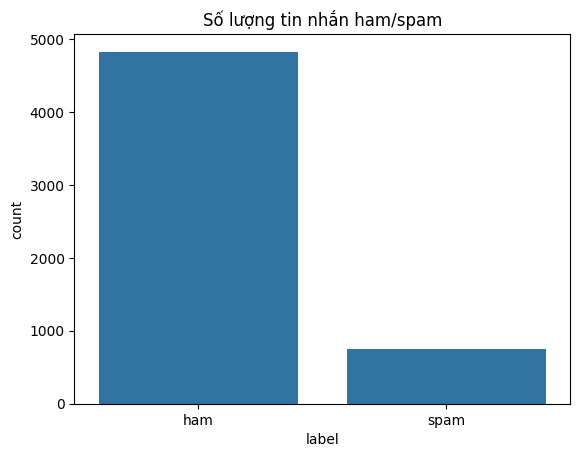

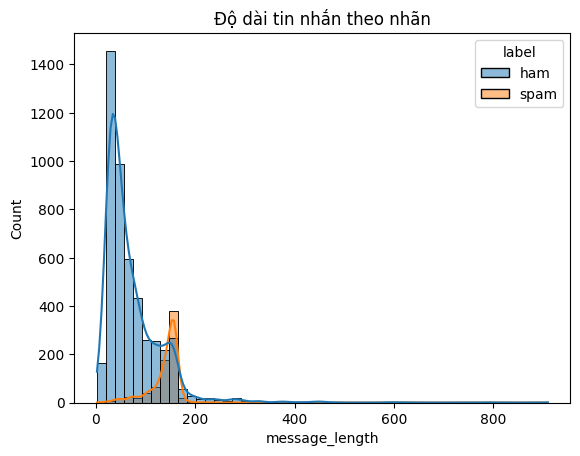

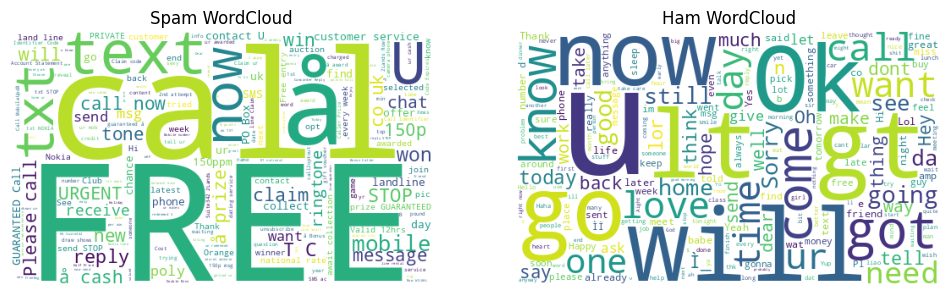

  label                                    cleaned_message
0   ham  go jurong point crazy available bugis n great ...
1   ham                            ok lar joking wif u oni
2  spam  free entry wkly comp win fa cup final tkts st ...
3   ham                u dun say early hor u c already say
4   ham        nah dont think goes usf lives around though


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
# 🧾 BƯỚC 1: Đọc file từ ổ đĩa
duong_dan = "spam.csv"
# Tự động phát hiện encoding của file để tránh lỗi khi đọc
with open(duong_dan, "rb") as f:
    result = chardet.detect(f.read(10000))  # Đọc thử 10.000 byte
    encoding = result['encoding']
    print(f"Đã đoán encoding: {encoding}")
# Đọc dữ liệu và chuẩn hóa cột
df = pd.read_csv(duong_dan, encoding=encoding)
df = df[['v1', 'v2']]                    # Lấy 2 cột cần thiết
df.columns = ['label', 'message']       # Đặt tên cột rõ ràng
# 📊 BƯỚC 2: Khám phá dữ liệu (EDA)
# Thống kê số lượng ham/spam
print("Số lượng ham/spam:")
print(df['label'].value_counts())
# Vẽ biểu đồ cột số lượng
sns.countplot(data=df, x='label')
plt.title("Số lượng tin nhắn ham/spam")
plt.show()
# Tính độ dài tin nhắn
df['message_length'] = df['message'].apply(len)
# Vẽ biểu đồ phân bố độ dài tin nhắn
sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True)
plt.title("Độ dài tin nhắn theo nhãn")
plt.show()
# ☁️ BƯỚC 3: Tạo WordCloud
spam_text = ' '.join(df[df['label'] == 'spam']['message'])
ham_text = ' '.join(df[df['label'] == 'ham']['message'])
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(width=500, height=300, background_color='white').generate(spam_text))
plt.axis("off")
plt.title("Spam WordCloud")
plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=500, height=300, background_color='white').generate(ham_text))
plt.axis("off")
plt.title("Ham WordCloud")
plt.show()
# 🧹 BƯỚC 4: Làm sạch tin nhắn
# Đường dẫn đến file spam.csv của bạn
duong_dan = "spam.csv"
# Phát hiện encoding để tránh lỗi Unicode
with open(duong_dan, "rb") as f:
    encoding = chardet.detect(f.read())['encoding']
# Đọc dữ liệu và đổi tên cột
df = pd.read_csv(duong_dan, encoding=encoding)[['v1', 'v2']]
df.columns = ['label', 'message']
# Tải stopwords nếu chưa có
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Hàm làm sạch văn bản
def clean_message(msg):
    msg = msg.lower()                              # Chuyển sang chữ thường
    msg = re.sub(r'\d+', '', msg)                 # Xoá chữ số
    msg = re.sub(r'[^\w\s]', '', msg)             # Xoá dấu câu
    words = msg.split()                           # Tách từ
    words = [w for w in words if w not in stop_words]  # Bỏ stop words
    return ' '.join(words)
# Tạo cột mới chứa tin nhắn đã làm sạch
df['cleaned_message'] = df['message'].apply(clean_message)
# Chỉ giữ lại hai cột yêu cầu: nhãn và tin nhắn đã làm sạch
df_output = df[['label', 'cleaned_message']]
# Hiển thị 5 dòng đầu để kiểm tra
print(df_output.head())

Code 2

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

duong_dan = "spam.csv"

# BƯỚC 1: Chuyển đổi nhãn sang dạng số
# Chuyển 'ham' thành 0, 'spam' thành 1
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

# In ra để kiểm tra
print("Số lượng mẫu theo nhãn số:")
print(df['label_num'].value_counts())

# BƯỚC 2: Chuyển đổi tin nhắn thành đặc trưng số
# Sử dụng CountVectorizer (Mô hình Bag of Words)
count_vectorizer = CountVectorizer(max_features=5000)  # Giới hạn 5000 từ phổ biến nhất
X_count = count_vectorizer.fit_transform(df['cleaned_message'])

# Sử dụng TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_message'])

# In ra kích thước của dữ liệu sau khi chuyển đổi
print(f"Kích thước dữ liệu CountVectorizer: {X_count.shape}")
print(f"Kích thước dữ liệu TF-IDF: {X_tfidf.shape}")

# BƯỚC 3: Chia dữ liệu thành tập huấn luyện và tập kiểm tra
# Sử dụng cả hai loại đặc trưng để so sánh
# Sử dụng CountVectorizer
X_count_train, X_count_test, y_count_train, y_count_test = train_test_split(
    X_count, df['label_num'], test_size=0.2, random_state=42, stratify=df['label_num']
)

# Sử dụng TF-IDF
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(
    X_tfidf, df['label_num'], test_size=0.2, random_state=42, stratify=df['label_num']
)

# BƯỚC 4: Lưu từ vựng để sử dụng sau này
count_vocab = count_vectorizer.get_feature_names_out()
tfidf_vocab = tfidf_vectorizer.get_feature_names_out()

# In ra thông tin về tập huấn luyện và kiểm tra
print("\nThông tin về bộ dữ liệu đã chia:")
print(f"Số lượng mẫu huấn luyện: {X_count_train.shape[0]}")
print(f"Số lượng mẫu kiểm tra: {X_count_test.shape[0]}")
print(f"Tỷ lệ spam trong tập huấn luyện: {y_count_train.mean()*100:.2f}%")
print(f"Tỷ lệ spam trong tập kiểm tra: {y_count_test.mean()*100:.2f}%")


output_summary = {
    'CountVectorizer': {
        'X_train shape': X_count_train.shape,
        'X_test shape': X_count_test.shape,
        'y_train shape': y_count_train.shape,
        'y_test shape': y_count_test.shape,
        'vocabulary size': len(count_vocab)
    },
    'TfidfVectorizer': {
        'X_train shape': X_tfidf_train.shape,
        'X_test shape': X_tfidf_test.shape,
        'y_train shape': y_tfidf_train.shape,
        'y_test shape': y_tfidf_test.shape,
        'vocabulary size': len(tfidf_vocab)
    }
}

print("\nTổng kết:")
for method, details in output_summary.items():
    print(f"\n{method}:")
    for key, value in details.items():
        print(f"  - {key}: {value}")

Số lượng mẫu theo nhãn số:
label_num
0    4825
1     747
Name: count, dtype: int64
Kích thước dữ liệu CountVectorizer: (5572, 5000)
Kích thước dữ liệu TF-IDF: (5572, 5000)

Thông tin về bộ dữ liệu đã chia:
Số lượng mẫu huấn luyện: 4457
Số lượng mẫu kiểm tra: 1115
Tỷ lệ spam trong tập huấn luyện: 13.42%
Tỷ lệ spam trong tập kiểm tra: 13.36%

Tổng kết:

CountVectorizer:
  - X_train shape: (4457, 5000)
  - X_test shape: (1115, 5000)
  - y_train shape: (4457,)
  - y_test shape: (1115,)
  - vocabulary size: 5000

TfidfVectorizer:
  - X_train shape: (4457, 5000)
  - X_test shape: (1115, 5000)
  - y_train shape: (4457,)
  - y_test shape: (1115,)
  - vocabulary size: 5000


Coder 3

Import thư viện và định nghĩa mô hình

In [12]:
# Imports chung
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Imports model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Import cho cross-validation
from sklearn.model_selection import cross_val_score

# Import pickle để lưu mô hình
import pickle

# Định nghĩa danh sách mô hình
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(n_estimators=50),
    'Bagging': BaggingClassifier(n_estimators=50),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

Hàm đánh giá và dùng Cross- Validation đánh giá sự ổn đinh của mô *hình*

In [13]:
# Hàm đánh giá mô hình trên tập test
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1}

# Hàm đánh giá cross-validation
def evaluate_model_cv(model, X, y, cv=5, scoring='f1'):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return scores.mean(), scores.std()

Cross-validation

In [14]:
import time
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Đánh giá bằng Cross-validation (cho tất cả mô hình)
cv_results = []
y = df['label_num']  # Sử dụng df['label_num'] làm nhãn

for feat_name, X in {
    'Count': X_count,
    'TF-IDF': X_tfidf
}.items():
    print(f"Đang xử lý đặc trưng: {feat_name}")
    for name, model in models.items():
        try:
            start_time = time.time()
            mean_score, std_score = evaluate_model_cv(model, X, y, cv=3, scoring='f1')
            elapsed_time = time.time() - start_time
            if elapsed_time > 60:
                print(f"Mô hình {name} trên {feat_name} quá chậm, bỏ qua sau {elapsed_time:.2f} giây")
                continue
            # Thêm chỉ số tổng hợp (Mean - k * Std, với k=0.5)
            stability_score = mean_score - 0.5 * std_score
            cv_results.append({
                'Feature': feat_name,
                'Model': name,
                'Mean F1-score': mean_score,
                'Std F1-score': std_score,
                'Stability Score': stability_score
            })
        except Exception as e:
            print(f"Lỗi khi chạy cross-validation cho {name} trên {feat_name}: {str(e)}")

# Chuyển kết quả thành DataFrame
df_cv_results = pd.DataFrame(cv_results)
print("\nKết quả Cross-validation:")
display(df_cv_results)

Đang xử lý đặc trưng: Count


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:54:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:54:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:54:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Đang xử lý đặc trưng: TF-IDF


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:56:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:56:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:56:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Kết quả Cross-validation:


,Feature,Model,Mean F1-score,Std F1-score,Stability Score
0,Count,MultinomialNB,0.891162,0.004780,0.888772
1,Count,LogisticRegression,0.906587,0.005324,0.903925
2,Count,SVM,0.909519,0.005379,0.906829
3,Count,DecisionTree,0.815786,0.004087,0.813743
4,Count,RandomForest,0.877952,0.016755,0.869575
5,Count,KNN,0.569489,0.040196,0.549391
6,Count,AdaBoost,0.632538,0.052080,0.606499
7,Count,Bagging,0.848197,0.015466,0.840464
8,Count,ExtraTrees,0.887132,0.005975,0.884145
9,Count,GradientBoosting,0.826888,0.023958,0.814909


Huấn luyện và đánh giá

In [15]:
# Huấn luyện và đánh giá trên tập train/test
results = []
for feat_name, (X_train, X_test, y_train, y_test) in {
    'Count': (X_count_train, X_count_test, y_count_train, y_count_test),
    'TF-IDF': (X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test)
}.items():
    print(f"\nĐánh giá với đặc trưng trên tập test: {feat_name}")
    for name, model in models.items():
        model.fit(X_train, y_train)
        res = evaluate_model(name, model, X_test, y_test)
        res['Feature'] = feat_name
        results.append(res)

# Chuyển kết quả trên tập test thành DataFrame
df_results = pd.DataFrame(results)
print("\nKết quả trên tập test:")
display(df_results)


Đánh giá với đặc trưng trên tập test: Count


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:56:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Đánh giá với đặc trưng trên tập test: TF-IDF


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:57:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Kết quả trên tập test:


,Model,Accuracy,Precision,Recall,F1-score,Feature
0,MultinomialNB,0.974888,0.917241,0.892617,0.904762,Count
1,LogisticRegression,0.981166,1.000000,0.859060,0.924188,Count
2,SVM,0.984753,0.992537,0.892617,0.939929,Count
3,DecisionTree,0.959641,0.866197,0.825503,0.845361,Count
4,RandomForest,0.977578,1.000000,0.832215,0.908425,Count
5,KNN,0.923767,1.000000,0.429530,0.600939,Count
6,AdaBoost,0.923767,0.775862,0.604027,0.679245,Count
7,Bagging,0.966816,0.924242,0.818792,0.868327,Count
8,ExtraTrees,0.977578,1.000000,0.832215,0.908425,Count
9,GradientBoosting,0.961435,0.964912,0.738255,0.836502,Count


Hiển thị top 5 mô hình tốt nhất


Top 5 mô hình dựa trên Stability Score (Cross-validation):


,Feature,Model,Mean F1-score,Std F1-score,Stability Score
13,TF-IDF,SVM,0.918297,0.007431,0.914582
2,Count,SVM,0.909519,0.005379,0.906829
1,Count,LogisticRegression,0.906587,0.005324,0.903925
15,TF-IDF,RandomForest,0.897043,0.013996,0.890045
0,Count,MultinomialNB,0.891162,0.004780,0.888772


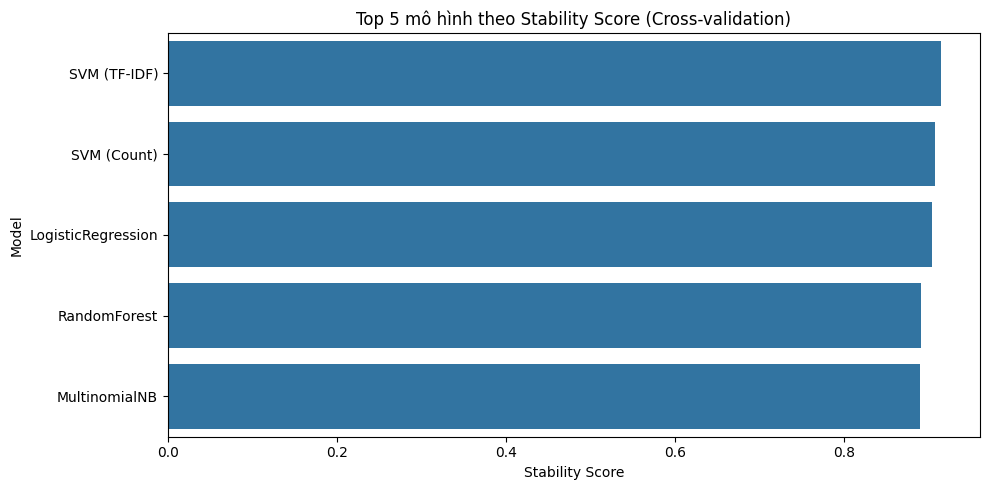


Top 5 mô hình dựa trên F1-score trên tập test:


,Feature,Model,Accuracy,Precision,Recall,F1-score
2,Count,SVM,0.984753,0.992537,0.892617,0.939929
13,TF-IDF,SVM,0.983857,1.000000,0.879195,0.935714
1,Count,LogisticRegression,0.981166,1.000000,0.859060,0.924188
19,TF-IDF,ExtraTrees,0.977578,0.992063,0.838926,0.909091
4,Count,RandomForest,0.977578,1.000000,0.832215,0.908425


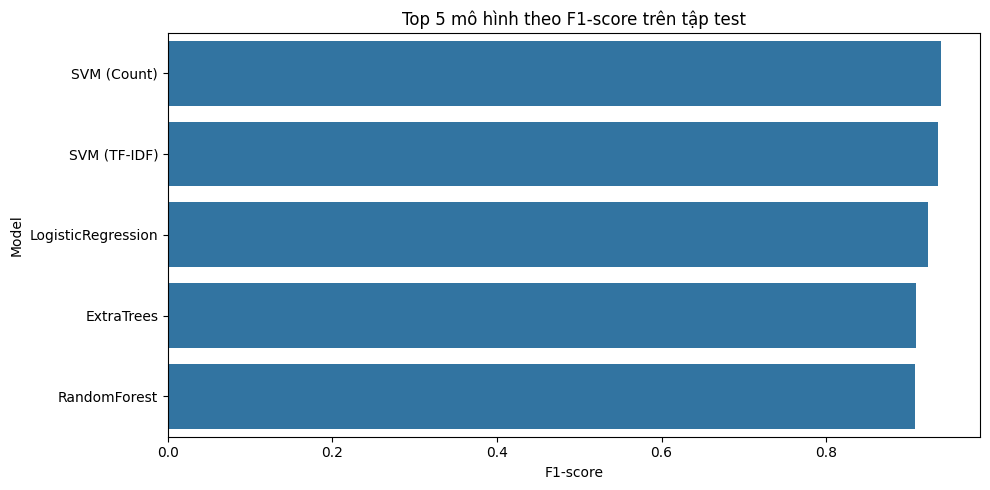


Top 5 mô hình dựa trên Composite Score:


,Feature,Model,Stability Score,F1-score,Composite Score
13,TF-IDF,SVM,0.914582,0.935714,0.925148
2,Count,SVM,0.906829,0.939929,0.923379
1,Count,LogisticRegression,0.903925,0.924188,0.914056
19,TF-IDF,ExtraTrees,0.888590,0.909091,0.898840
0,Count,MultinomialNB,0.888772,0.904762,0.896767


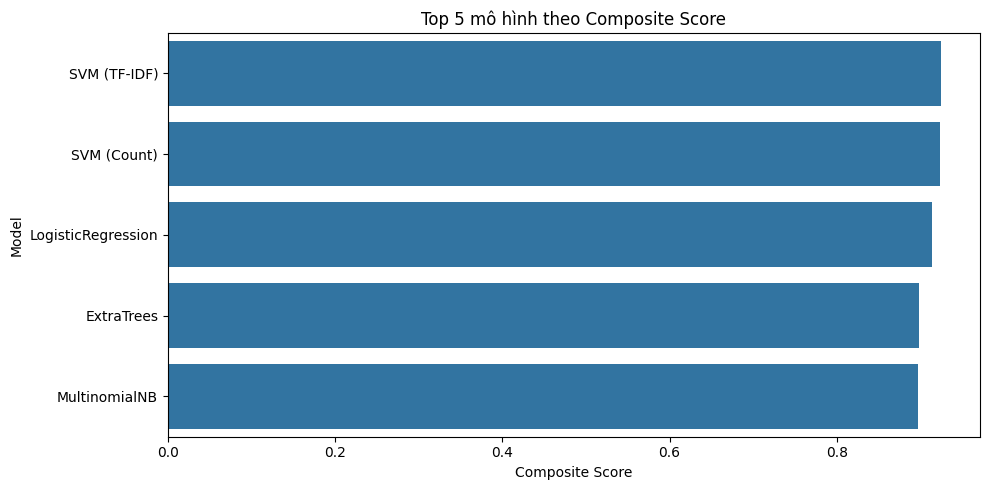

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Giả sử df_cv_results và df_results đã được định nghĩa ở trên

# Đoạn 7: Hiển thị top 5 mô hình dựa trên Stability Score, F1-score trên tập test, và Composite Score

# 1. Top 5 mô hình dựa trên Stability Score từ Cross-validation
top5_stability = df_cv_results.sort_values('Stability Score', ascending=False).head(5)
print("\nTop 5 mô hình dựa trên Stability Score (Cross-validation):")
display(top5_stability[['Feature', 'Model', 'Mean F1-score', 'Std F1-score', 'Stability Score']])

# Tạo cột mới cho trục y: chỉ thêm feature khi mô hình trùng tên
top5_stability['Model_Feature'] = top5_stability.apply(
    lambda row: f"{row['Model']} ({row['Feature']})" if top5_stability['Model'].duplicated(keep=False).loc[row.name] else row['Model'],
    axis=1
)

# Vẽ biểu đồ cho top 5 Stability Score
plt.figure(figsize=(10, 5))
sns.barplot(data=top5_stability, x='Stability Score', y='Model_Feature')
plt.title("Top 5 mô hình theo Stability Score (Cross-validation)")
plt.xlabel("Stability Score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# 2. Top 5 mô hình dựa trên F1-score từ tập test
top5_f1_test = df_results.sort_values('F1-score', ascending=False).head(5)
print("\nTop 5 mô hình dựa trên F1-score trên tập test:")
display(top5_f1_test[['Feature', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']])

# Tạo cột mới cho trục y: chỉ thêm feature khi mô hình trùng tên
top5_f1_test['Model_Feature'] = top5_f1_test.apply(
    lambda row: f"{row['Model']} ({row['Feature']})" if top5_f1_test['Model'].duplicated(keep=False).loc[row.name] else row['Model'],
    axis=1
)

# Vẽ biểu đồ cho top 5 F1-score trên tập test
plt.figure(figsize=(10, 5))
sns.barplot(data=top5_f1_test, x='F1-score', y='Model_Feature')
plt.title("Top 5 mô hình theo F1-score trên tập test")
plt.xlabel("F1-score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# 3. Tính Composite Score và hiển thị top 5
combined_results = pd.merge(df_cv_results[['Feature', 'Model', 'Stability Score']],
                            df_results[['Feature', 'Model', 'F1-score']],
                            on=['Feature', 'Model'],
                            how='inner')
combined_results['Composite Score'] = 0.5 * combined_results['Stability Score'] + 0.5 * combined_results['F1-score']
top5_composite = combined_results.sort_values('Composite Score', ascending=False).head(5)
print("\nTop 5 mô hình dựa trên Composite Score:")
display(top5_composite[['Feature', 'Model', 'Stability Score', 'F1-score', 'Composite Score']])

# Tạo cột mới cho trục y: chỉ thêm feature khi mô hình trùng tên
top5_composite['Model_Feature'] = top5_composite.apply(
    lambda row: f"{row['Model']} ({row['Feature']})" if top5_composite['Model'].duplicated(keep=False).loc[row.name] else row['Model'],
    axis=1
)

# Vẽ biểu đồ cho top 5 Composite Score
plt.figure(figsize=(10, 5))
sns.barplot(data=top5_composite, x='Composite Score', y='Model_Feature')
plt.title("Top 5 mô hình theo Composite Score")
plt.xlabel("Composite Score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

Confusion Matrix cho 3 model tối ưu nhất


Model: SVM trên TF-IDF (Stability Score=0.9146, F1-test=0.9357, Composite Score=0.9251)


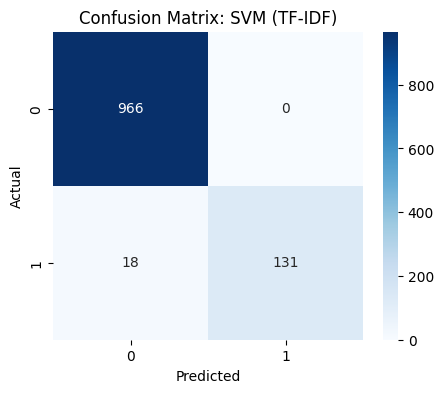


Model: SVM trên Count (Stability Score=0.9068, F1-test=0.9399, Composite Score=0.9234)


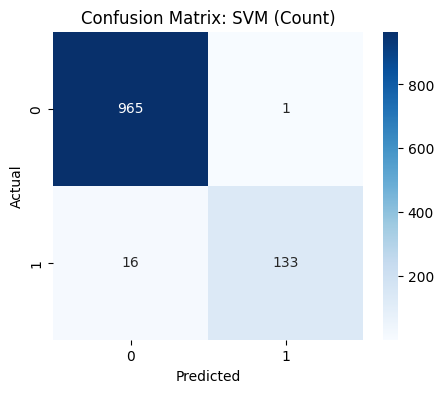


Model: LogisticRegression trên Count (Stability Score=0.9039, F1-test=0.9242, Composite Score=0.9141)


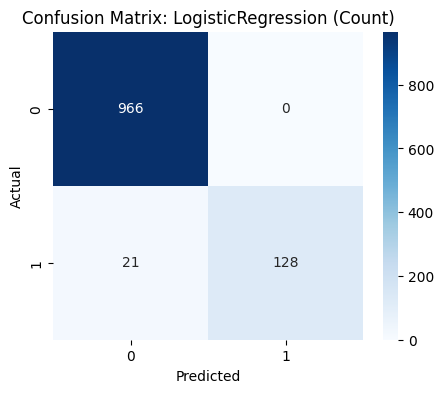

In [29]:
# Đoạn 8: Sử dụng top 3 từ Composite Score để vẽ ma trận nhầm lẫn
top3_overall = top5_composite.head(3)

for index, row in top3_overall.iterrows():
    model_name = row['Model']
    feat = row['Feature']
    stability_score = row['Stability Score']
    f1_test = row['F1-score']
    composite_score = row['Composite Score']

    print(f"\nModel: {model_name} trên {feat} (Stability Score={stability_score:.4f}, F1-test={f1_test:.4f}, Composite Score={composite_score:.4f})")

    # Chọn dữ liệu train/test dựa trên đặc trưng
    best_model = models[model_name]
    if feat == 'TF-IDF':
        X_tr, X_te, y_tr, y_te = X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test
    else:
        X_tr, X_te, y_tr, y_te = X_count_train, X_count_test, y_count_train, y_count_test

    # Huấn luyện mô hình và dự đoán
    best_model.fit(X_tr, y_tr)
    y_pred = best_model.predict(X_te)
    cm = confusion_matrix(y_te, y_pred)

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {model_name} ({feat})')
    plt.show()

Lưu lại Model

In [18]:
with open('best_spam_model.pkl','wb') as f:
    pickle.dump({
        'model': best_model,
        'vectorizer': tfidf_vectorizer
    }, f)
print("Đã lưu model và vectorizer vào best_spam_model.pkl")


Đã lưu model và vectorizer vào best_spam_model.pkl
